# 1) Importations

In [1]:
%pylab inline
import pandas as pd
import os
import seaborn as sns
from sklearn import preprocessing, decomposition, metrics, linear_model, model_selection, cluster, svm
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_clustering(data, y, centers) :
    """
    Function to plot clustering with annotations
    """

    fig, ax = plt.subplots(figsize=(7,7))
    #create a scatter plot
    ax.scatter(data[:, 0], data[:, 1], c=y, s=10, cmap='plasma')

    #select cluster centers
    ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200)
    ax.set_xlabel("Order's amount (log-scale)", fontsize=12)
    ax.set_ylabel("Order's bulk ratio (log-scale)", fontsize=12)

    # Number of customers in each cluster?
    clustering_population = pd.DataFrame(pd.Series(y).value_counts().sort_index(), columns = ['NumberCustomers']).T
    
    # Get abscissa limits
    x_min, x_max = ax.get_xlim()
    # Add cluster population
    for i in range(clustering_population.shape[1]) :
        # Annotation arrows for clusters population
        ax.annotate(str(clustering_population.iloc[0, i]), xy=(centers[i, 0], centers[i, 1]),  xycoords='data',
                    bbox=dict(boxstyle="round", fc="none", ec="gray"),
                    xytext=(x_max - 1, centers[i, 1] - 1), ha='center',
                    arrowprops=dict(arrowstyle="->"))
        # Number of cluster
        ax.text(centers[i, 0], centers[i, 1], str(clustering_population.columns.values[i]), weight='bold',
                fontsize=10, color='white', horizontalalignment='center', verticalalignment='center')
    ax.text(x_max - 1, -1.5, "Populations", fontsize=12, horizontalalignment='center');    
    

def clustering(X) :
    """
    Function for kmeans-clustering with 5 clusters
    """
    # Log-scale the data
    X_temp = X.apply(lambda x : np.add(x, 0.1)) # Avoiding taking the log of zeros
    X_log = X_temp.apply(np.log)
    data = X_log.values
    
    # Actual clustering
    nclust = 5
    kmeans = cluster.KMeans(n_clusters=nclust, n_init=100)
    kmeans.fit(data)
    y = kmeans.predict(data)
    silhouette_avg = metrics.silhouette_score(data, y)
    print('silhouette score : {:<.3f} for {} clusters'.format(silhouette_avg, nclust))
    
    #select cluster centers
    centers = kmeans.cluster_centers_
    
    # Plot
    plot_clustering(data, y, centers)
    
    return y, kmeans

In [3]:
def plot_labels(ax, data, y) :
    """
    Function to create scatter plots displaying labels of clusters instead of markers
    """
    # Extract colors
    cmap = matplotlib.cm.get_cmap('plasma')
    unique_labels = list(set(np.unique(y)))
    colors = cmap(unique_labels)
    colors=['b','r','g','m','k']
    
    # Plot
    for i, txt in enumerate(y):
        fontdict = {'fontsize' : 9,
                    'color' : colors[txt]}
        # Labels
        ax.text(data[i, 0], data[i, 1], str(txt), fontdict=fontdict, 
                horizontalalignment='center', verticalalignment='center').set_clip_on(True)
    # Set boundaries
    ax.set_xlim(data[:,0].min() - 1, data[:,0].max() + 1)
    ax.set_ylim(data[:,1].min() - 1, data[:,1].max() + 1)
    ax.set_xlabel("Order's amount (log-scale)", fontsize=12)
    ax.set_ylabel("Order's bulk ratio (log-scale)", fontsize=12)
    
    return ax

In [4]:
def plot_confusion_matrix(ax, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    # ax.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, classes)
    ax.set_yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# 2) Data

In [199]:
# Getting current path
path = os.getcwd()
try :
    customers_df = pd.read_csv(path + "/data/segmented_customers.csv", index_col='CustomerID_enc')
    print("Loading customers dataset")
    display(customers_df.head())
    online_retail_df = pd.read_csv(path + "/data/online_retail_clean_segmented.csv")
    print("Loading online retail dataset")
    display(online_retail_df.head())
except FileNotFoundError:
    print("ERROR : check if the files are in the 'data' folder")

Loading customers dataset


,Amount,Bulk,Segment
CustomerID_enc,,,
1,40.737961,3.524379,3
2,7.198267,3.167508,0
3,20.408485,2.778461,3
4,15.971864,6.182251,1
5,15.453333,5.758253,1


Loading online retail dataset


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_enc,Amount,Bulk,Segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,3626,15.30,1.690141,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,3626,20.34,1.366743,3
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,3626,22.00,2.133333,3
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,3626,20.34,1.366743,3
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,3626,20.34,1.366743,3


# 3) Train - Test split

Our training features are "Amount" and "Bulk", our target feature is "Segment"

## 3.1) Customers Random Train - Test split

We will use sklearn random split without taking account that this is temporal data we are dealing with.

In [200]:
train_df = customers_df.sample(frac=0.7, random_state=0)
test_df = customers_df.loc[numpy.setdiff1d(customers_df.index.values, train_df.index.values), :]

In [201]:
X_train_rdm = train_df.loc[:, ["Amount", "Bulk"]]
X_test_rdm = test_df.loc[:, ["Amount", "Bulk"]]

But y_train and y_test are to be recomputed as those have been calculated with the X_test values (data leakage)

silhouette score : 0.366 for 5 clusters


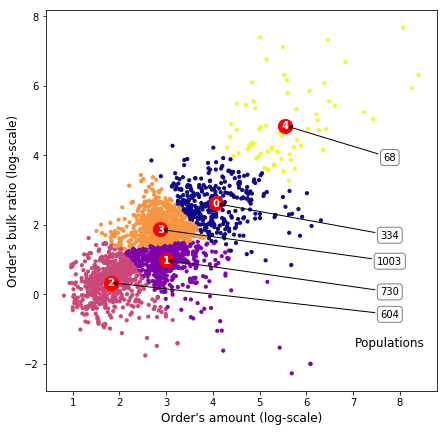

In [202]:
y_train_rdm, kmeans_train = clustering(X_train_rdm)

Predict our y_test from our training algorithm

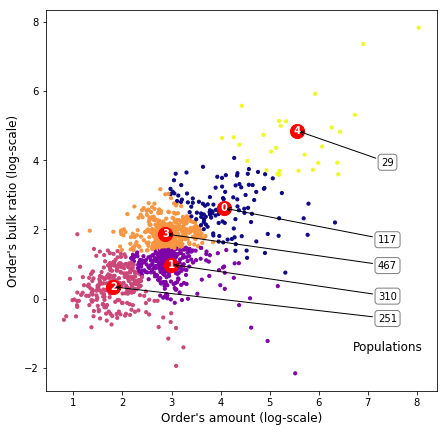

In [203]:
# Log-scale test-data
X_test_temp = X_test_rdm.apply(lambda x : np.add(x, 0.1)) # Avoiding taking the log of zeros
X_test_log = X_test_temp.apply(np.log)
# Predict y_test from training clustering
y_test_rdm = kmeans_train.predict(X_test_log.values)
# Plot output
plot_clustering(X_test_log.values, y_test_rdm, kmeans_train.cluster_centers_)

Getting test customers first invoice dataframe in order to see if the prediction based on first invoice is representative of customer's history

In [204]:
# Get testing customers
test_custs = test_df.index.values
# Slicing main data for testing customers
test_retail_df = online_retail_df[online_retail_df.CustomerID_enc.isin(test_custs)]
# Aggregate test customers 1st invoice
test_cust_first_invoice_df = test_retail_df.groupby('CustomerID_enc').agg({'Amount': lambda x: x.head(1),
                                                                           'Bulk': lambda x: x.head(1)})

Aggregating customers by order (not invoice) in order to test if classification is better on first order rather than first invoice

In [255]:
temp_agg = test_retail_df.groupby(['InvoiceDate', 'CustomerID_enc']).agg({'Amount': lambda x: x.mean(),
                                                                          'Bulk': lambda x: x.mean()})
temp_agg['cust_id'] = temp_agg.index.get_level_values(1)
test_cust_first_order_df = temp_agg.drop_duplicates(subset=['cust_id'], keep='first').loc[:, ['Amount', 'Bulk']]
test_cust_first_order_df.index = test_cust_first_order_df.index.droplevel(0)
test_cust_first_order_df = test_cust_first_order_df.sort_index(axis=0)

## 3.2) Temporal Train - Test split

We will split our dataset according to the purchase date and induce some data leakage as customers mey be in both train and test sets

In [74]:
# Sorting df by invoice date in case it is not aleady done
online_retail_df = online_retail_df.sort_values(by='InvoiceDate')

In [75]:
test_size = 0.3
n_train = math.floor(online_retail_df.shape[0] * (1 - test_size))

# Try not to cut on a customer's order but between two orders
last_cust = online_retail_df.iloc[:n_train, :].tail(1).CustomerID_enc.values
prev_cust = online_retail_df.iloc[:n_train, :].tail(2).loc[:,'CustomerID_enc'].iloc[0]
print("First train cut index : %i" % n_train)
if prev_cust != last_cust :
    while prev_cust != last_cust :
        n_train -= 1
        last_cust = online_retail_df.iloc[:n_train, :].tail(1).CustomerID_enc.values
        prev_cust = online_retail_df.iloc[:n_train, :].tail(2).loc[:,'CustomerID_enc'].iloc[0]
print("Final train cut index : %i" % n_train)   

train_df = online_retail_df.iloc[:n_train, :]
test_df = online_retail_df.iloc[n_train:, :]

First train cut index : 244205
Final train cut index : 244204


Transform data into customers_df

In [76]:
# Aggregate train df
train_cust_df = train_df.groupby('CustomerID_enc').agg({'Amount': lambda x: x.mean(),
                                                        'Bulk': lambda x: x.mean(),
                                                        'Segment': lambda x: x.mean()})
# Select X_train
X_train_time = train_cust_df.loc[:, ["Amount", "Bulk"]]

# Aggregate test df
test_cust_df = test_df.groupby('CustomerID_enc').agg({'Amount': lambda x: x.mean(),
                                                      'Bulk': lambda x: x.mean(),
                                                      'Segment': lambda x: x.mean()})
# Select X_test
X_test_time = test_cust_df.loc[:, ["Amount", "Bulk"]]

In [77]:
X_train_time.shape

(3350, 2)

But y_train and y_test are to be recomputed as those have been calculated with the X_test values (data leakage)

silhouette score : 0.356 for 5 clusters


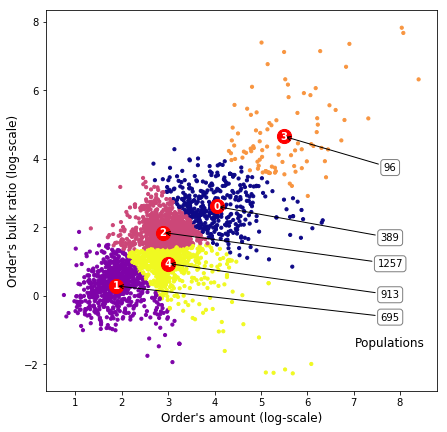

In [78]:
y_train_time, kmeans_train_time = clustering(X_train_time)

Predict our y_test from our training algorithm

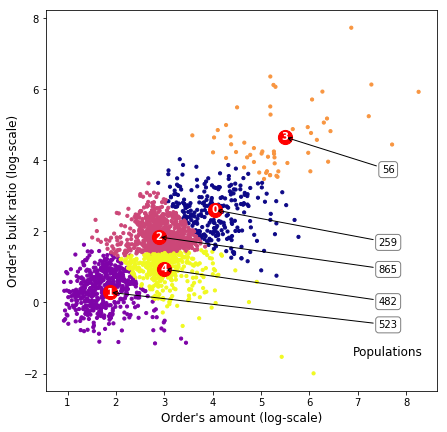

In [79]:
# Log-scale test-data
X_test_temp = X_test_time.apply(lambda x : np.add(x, 0.1)) # Avoiding taking the log of zeros
X_test_time_log = X_test_temp.apply(np.log)
# Predict y_test from training clustering
y_test_time = kmeans_train_time.predict(X_test_time_log.values)
# Plot output
plot_clustering(X_test_time_log.values, y_test_time, kmeans_train_time.cluster_centers_)

## 3.3) All Data Random Train - Test split

We will split our dataset randomly and induce some data leakage as customers will most likely be in both train and test sets

In [80]:
train_df = online_retail_df.sample(frac=0.7, random_state=0)
test_df = online_retail_df.loc[numpy.setdiff1d(online_retail_df.index.values, train_df.index.values), :]

Transform data into customers_df

In [81]:
# Aggregate train df
train_cust_df = train_df.groupby('CustomerID_enc').agg({'Amount': lambda x: x.mean(),
                                                        'Bulk': lambda x: x.mean(),
                                                        'Segment': lambda x: x.mean()})
# Select X_train
X_train_random = train_cust_df.loc[:, ["Amount", "Bulk"]]

# Aggregate test df
test_cust_df = test_df.groupby('CustomerID_enc').agg({'Amount': lambda x: x.mean(),
                                                      'Bulk': lambda x: x.mean(),
                                                      'Segment': lambda x: x.mean()})
# Select X_test
X_test_random = test_cust_df.loc[:, ["Amount", "Bulk"]]

But y_train and y_test are to be recomputed as those have been calculated with the X_test values (data leakage)

silhouette score : 0.357 for 5 clusters


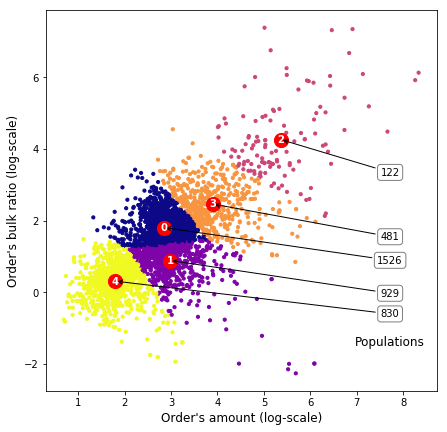

In [82]:
y_train_random, kmeans_train_random = clustering(X_train_random)

Predict our y_test from our training algorithm

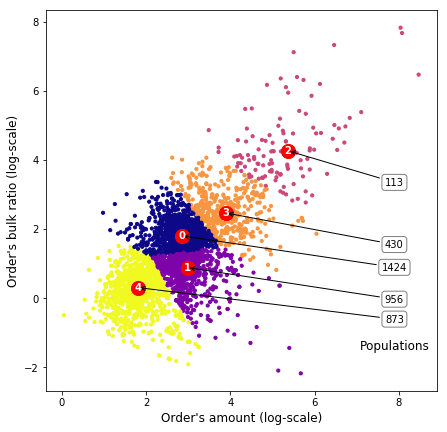

In [83]:
# Log-scale test-data
X_test_temp = X_test_random.apply(lambda x : np.add(x, 0.1)) # Avoiding taking the log of zeros
X_test_random_log = X_test_temp.apply(np.log)
# Predict y_test from training clustering
y_test_random = kmeans_train_random.predict(X_test_random_log.values)
# Plot output
plot_clustering(X_test_random_log.values, y_test_random, kmeans_train_random.cluster_centers_)

# 4) Classification

## 4.1) On Customers Random Split

### 4.1.1) Logistic regression

In [208]:
# Create logistic regression
lr = linear_model.LogisticRegression()
# Set parameters for grid search
params = {'C': np.logspace(-3, 3, 7) , 'penalty':['l1','l2']}
# Run Grid Search cross validation
lr_gs = model_selection.GridSearchCV(lr, params, scoring='accuracy', cv=10)
lr_gs.fit(X_train_rdm, y_train_rdm)
print(lr_gs.best_params_)
# Set best parameters
lr.set_params(**lr_gs.best_params_)
# Train logistic regression
lr.fit(X_train_rdm, y_train_rdm)
# Prediction output over test set
y_pred_lr = lr.predict(X_test_rdm)

{'C': 10.0, 'penalty': 'l1'}


In [209]:
# Compute accuracy
accuracy = metrics.accuracy_score(y_test_rdm, y_pred_lr)
print("Accuracy score = %.2f" % accuracy)
# Compute RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_test_rdm, y_pred_lr))
print("RMSE = %.2f" % rmse)
# Compute f-score
fscore = metrics.f1_score(y_test_rdm, y_pred_lr, average='macro')
print("f-score = %.2f" % fscore)

Accuracy score = 0.76
RMSE = 1.11
f-score = 0.70


This is an encouraging score

### Nevertheless, let's see how good is our prediction

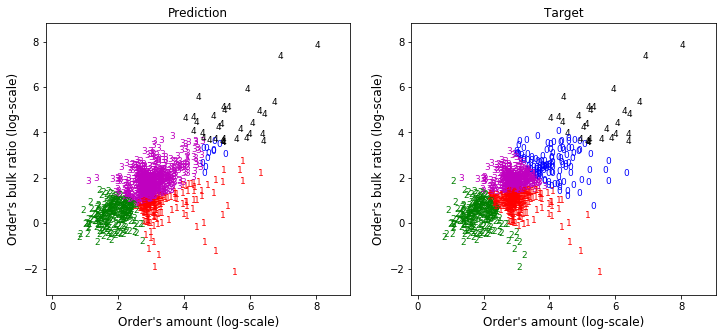

In [210]:
# Comparison subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
# Plot prediction
plot_labels(ax1, X_test_log.values, y_pred_lr)
ax1.set_title('Prediction', fontsize=12)
# Plot target
plot_labels(ax2, X_test_log.values, y_test_rdm)
ax2.set_title('Target', fontsize=12);

Extremes clusters seem to be rather well predicted, but average-clusters are mixed-up

THE DARKER THE MORE ACCURATE


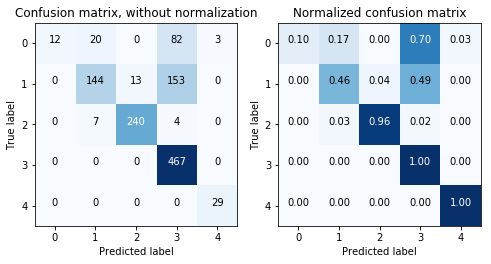

In [211]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_rdm, y_pred_lr)
np.set_printoptions(precision=2)
# Class names
class_names = list(set(y_test_rdm.tolist()))
# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
# Plot non-normalized confusion matrix
plot_confusion_matrix(ax1, cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(ax2, cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
print('\033[1m' + 'THE DARKER THE MORE ACCURATE' + '\033[0m')

The confusion maxtrices put numbers of what we can see from the scatter plots :
- **0** : only **48% predicted accurately**, 48% are predicted as 2
- **1** : **100% predicted accurately**
- **2** : **100% predicted accurately**
- **3** : only **8% predicted accurately**, 18% are predicted as 0, 4% are predicted as 1 and 71% are predicted as 2
- **4** : **96% predicted accurately**, 1% are predicted as 0 and 2% are predicted as 2

### 4.1.2) Support vector machine

In [225]:
# Create multi-class SVC
svmm = svm.LinearSVC()
# Set parameters for grid search
params = {'C': np.logspace(-3, 3, 7), 'multi_class':['ovr', 'crammer_singer']}
# Run Grid Search cross validation
svm_gs = model_selection.GridSearchCV(svmm, params, scoring='accuracy', cv=10)
svm_gs.fit(X_train_rdm, y_train_rdm)
print(svm_gs.best_params_)
# Set best parameters
svmm.set_params(**svm_gs.best_params_)
# Train algorithm
svmm.fit(X_train_rdm, y_train_rdm)
# Prediction output over test set
y_pred_svm = svmm.predict(X_test_rdm)

{'C': 10.0, 'multi_class': 'crammer_singer'}


In [226]:
# Compute accuracy
accuracy = metrics.accuracy_score(y_test_rdm, y_pred_svm)
print("Accuracy score = %.2f" % accuracy)
# Compute RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_test_rdm, y_pred_svm))
print("RMSE = %.2f" % rmse)
# Compute f-score
fscore = metrics.f1_score(y_test_rdm, y_pred_svm, average='macro')
print("f-score = %.2f" % fscore)

Accuracy score = 0.94
RMSE = 0.63
f-score = 0.89


This seems better than LogisticRegression

### Nevertheless, let's see how good is our prediction

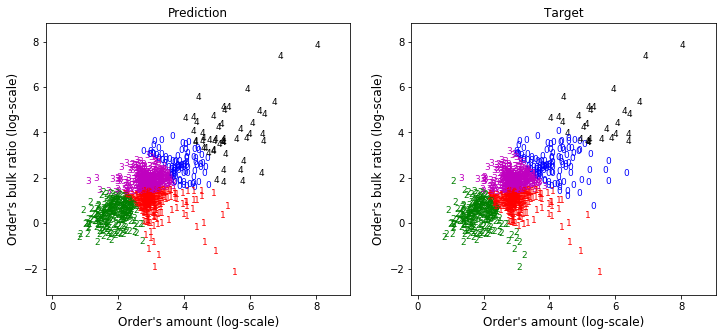

In [227]:
# Comparison subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
# Plot prediction
plot_labels(ax1, X_test_log.values, y_pred_svm)
ax1.set_title('Prediction')
# Plot target
plot_labels(ax2, X_test_log.values, y_test_rdm)
ax2.set_title('Target');

Except for a few values which seem to be mispredicted, nothing seems off about our prediction at first glance

THE DARKER THE MORE ACCURATE


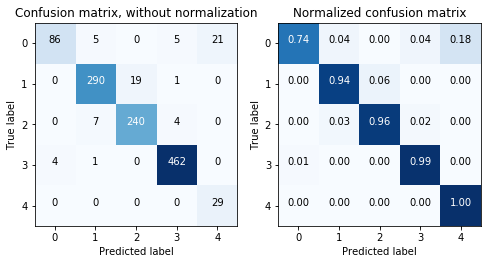

In [228]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_rdm, y_pred_svm)
np.set_printoptions(precision=2)
# Class names
class_names = list(set(y_test_rdm.tolist()))
# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
# Plot non-normalized confusion matrix
plot_confusion_matrix(ax1, cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(ax2, cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
print('\033[1m' + 'THE DARKER THE MORE ACCURATE' + '\033[0m')

The matrix talks for itself, the classifier is pretty accurate. A little less for 1 but there is few of them.

Coloring test customers history with test customers first invoice

0.4804088586030664


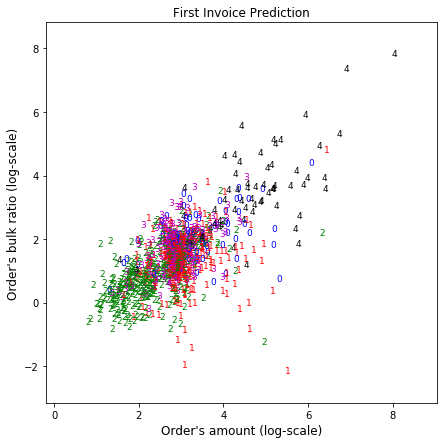

In [230]:
# Prediction output over first order test set
y_pred_svm_fi = svmm.predict(test_cust_first_invoice_df)
# Comparison subplots
fig, ax = plt.subplots(figsize=(7,7))
# Plot prediction
plot_labels(ax, X_test_log.values, y_pred_svm_fi)
ax.set_title('First Invoice Prediction')
# Compute accuracy
print(metrics.accuracy_score(y_test_rdm, y_pred_svm_fi))

Coloring test customers history with test customers first order

0.782793867120954


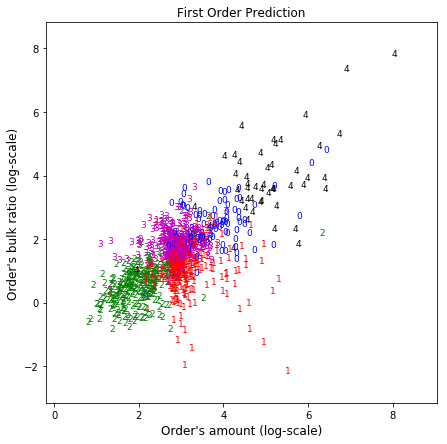

In [257]:
# Prediction output over first order test set
y_pred_svm_fo = svmm.predict(test_cust_first_order_df)
# Comparison subplots
fig, ax = plt.subplots(figsize=(7,7))
# Plot prediction
plot_labels(ax, X_test_log.values, y_pred_svm_fo)
ax.set_title('First Order Prediction')
# Compute accuracy
print(metrics.accuracy_score(y_test_rdm, y_pred_svm_fo))

## 4.2) On Temporal Split

### 4.2.1) Logistic regression

In [29]:
# Create logistic regression
lr = linear_model.LogisticRegression()
# Set parameters for grid search
params = {'C': np.logspace(-3, 3, 7) , 'penalty':['l1','l2']}
# Run Grid Search cross validation
lr_gs = model_selection.GridSearchCV(lr, params, scoring='accuracy', cv=10)
lr_gs.fit(X_train_time, y_train_time)
print(lr_gs.best_params_)
# Set best parameters
lr.set_params(**lr_gs.best_params_)
# Train logistic regression
lr.fit(X_train_time, y_train_time)
# Prediction output over test set
y_pred_lr = lr.predict(X_test_time)

{'C': 10.0, 'penalty': 'l2'}


In [30]:
# Compute accuracy
accuracy = metrics.accuracy_score(y_test_time, y_pred_lr)
print("Accuracy score = %.2f" % accuracy)
# Compute RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_test_time, y_pred_lr))
print("RMSE = %.2f" % rmse)
# Compute f-score
fscore = metrics.f1_score(y_test_time, y_pred_lr, average='macro')
print("f-score = %.2f" % fscore)

Accuracy score = 0.77
RMSE = 1.39
f-score = 0.70


This is an encouraging score

### Nevertheless, let's see how good is our prediction

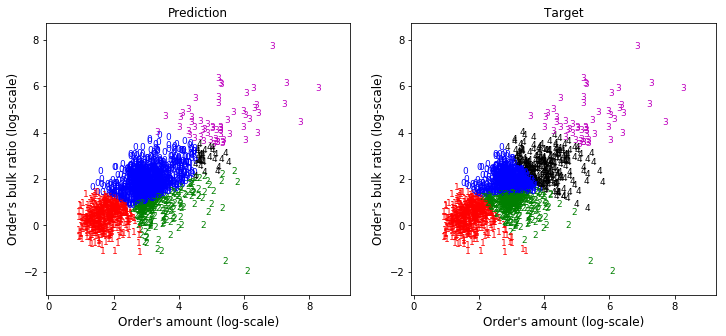

In [31]:
# Comparison subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
# Plot prediction
plot_labels(ax1, X_test_time_log.values, y_pred_lr)
ax1.set_title('Prediction')
# Plot target
plot_labels(ax2, X_test_time_log.values, y_test_time)
ax2.set_title('Target');

Extremes clusters seem to be rather well predicted, but average-clusters are mixed-up

THE DARKER THE MORE ACCURATE


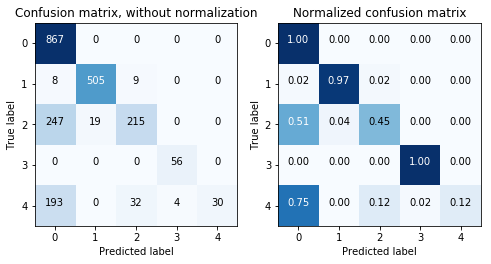

In [32]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_time, y_pred_lr)
np.set_printoptions(precision=2)
# Class names
class_names = list(set(y_test_time.tolist()))
# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
# Plot non-normalized confusion matrix
plot_confusion_matrix(ax1, cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(ax2, cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
print('\033[1m' + 'THE DARKER THE MORE ACCURATE' + '\033[0m')

Comparatively to the random train/test split the results might me a little worse. But nothing very different

### 4.2.2) Support vector machine

In [90]:
# Create multi-class SVC
svmm = svm.LinearSVC()
# Set parameters for grid search
params = {'C': np.logspace(-3, 3, 7), 'multi_class':['ovr', 'crammer_singer']}
# Run Grid Search cross validation
svm_gs = model_selection.GridSearchCV(svmm, params, scoring='accuracy', cv=10)
svm_gs.fit(X_train_time, y_train_time)
print(svm_gs.best_params_)
# Set best parameters
svmm.set_params(**svm_gs.best_params_)
# Train logistic regression
svmm.fit(X_train_time, y_train_time)
# Prediction output over test set
y_pred_svm = svmm.predict(X_test_time)

{'C': 10.0, 'multi_class': 'crammer_singer'}


In [91]:
# Compute accuracy
accuracy = metrics.accuracy_score(y_test_time, y_pred_svm)
print("Accuracy score = %.2f" % accuracy)
# Compute RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_test_time, y_pred_svm))
print("RMSE = %.2f" % rmse)
# Compute f-score
fscore = metrics.f1_score(y_test_time, y_pred_svm, average='macro')
print("f-score = %.2f" % fscore)

Accuracy score = 0.96
RMSE = 0.51
f-score = 0.95


This seems better than LogisticRegression

### Nevertheless, let's see how good is our prediction

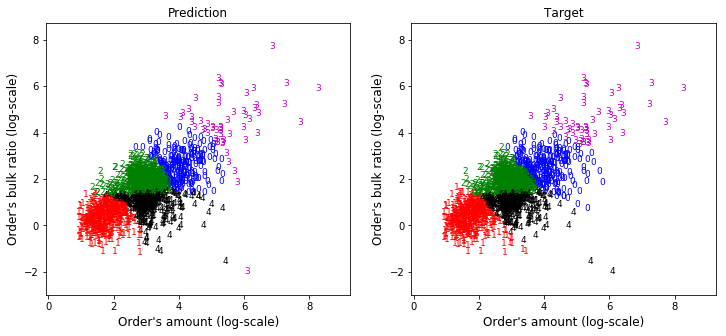

In [92]:
# Comparison subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
# Plot prediction
plot_labels(ax1, X_test_time_log.values, y_pred_svm)
ax1.set_title('Prediction')
# Plot target
plot_labels(ax2, X_test_time_log.values, y_test_time)
ax2.set_title('Target');

Except for a few values which seem to be mispredicted, nothing seems off about our prediction at first glance

THE DARKER THE MORE ACCURATE


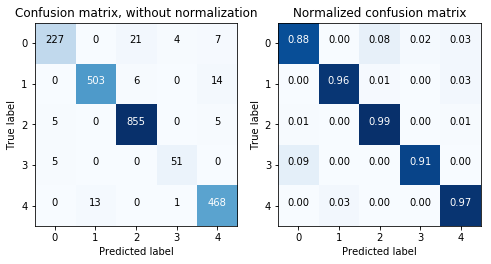

In [93]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_time, y_pred_svm)
np.set_printoptions(precision=2)
# Class names
class_names = list(set(y_test_time.tolist()))
# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
# Plot non-normalized confusion matrix
plot_confusion_matrix(ax1, cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(ax2, cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
print('\033[1m' + 'THE DARKER THE MORE ACCURATE' + '\033[0m')

The matrix talks for itself, the classifier is pretty accurate. A little less for 1 but there is few of them.

## 4.3) On Completely Random Split

### 4.3.1) Logistic regression

In [49]:
# Create logistic regression
lr = linear_model.LogisticRegression()
# Set parameters for grid search
params = {'C': np.logspace(-3, 3, 7) , 'penalty':['l1','l2']}
# Run Grid Search cross validation
lr_gs = model_selection.GridSearchCV(lr, params, scoring='accuracy', cv=10)
lr_gs.fit(X_train_random, y_train_random)
print(lr_gs.best_params_)
# Set best parameters
lr.set_params(**lr_gs.best_params_)
# Train logistic regression
lr.fit(X_train_random, y_train_random)
# Prediction output over test set
y_pred_lr = lr.predict(X_test_random)

{'C': 10.0, 'penalty': 'l2'}


In [50]:
# Compute accuracy
accuracy = metrics.accuracy_score(y_test_random, y_pred_lr)
print("Accuracy score = %.2f" % accuracy)
# Compute RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_test_random, y_pred_lr))
print("RMSE = %.2f" % rmse)
# Compute f-score
fscore = metrics.f1_score(y_test_random, y_pred_lr, average='macro')
print("f-score = %.2f" % fscore)

Accuracy score = 0.73
RMSE = 1.60
f-score = 0.67


This is an encouraging score

### Nevertheless, let's see how good is our prediction

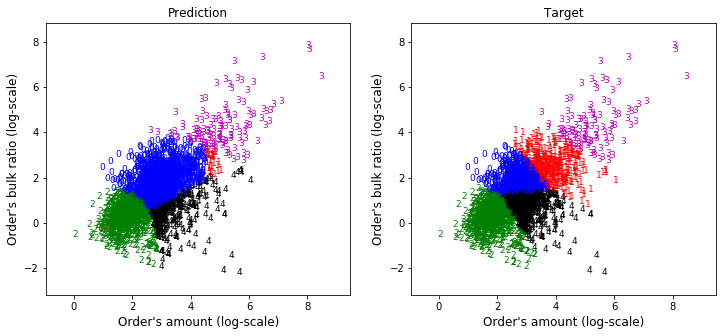

In [51]:
# Comparison subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
# Plot prediction
plot_labels(ax1, X_test_random_log.values, y_pred_lr)
ax1.set_title('Prediction')
# Plot target
plot_labels(ax2, X_test_random_log.values, y_test_random)
ax2.set_title('Target');

Extremes clusters seem to be rather well predicted, but average-clusters are mixed-up

THE DARKER THE MORE ACCURATE


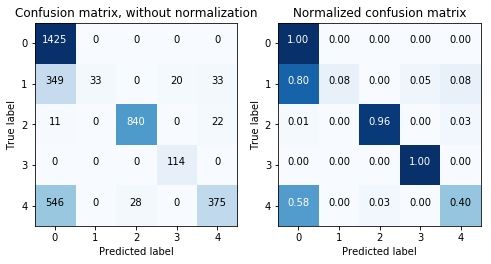

In [52]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_random, y_pred_lr)
np.set_printoptions(precision=2)
# Class names
class_names = list(set(y_test_random.tolist()))
# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
# Plot non-normalized confusion matrix
plot_confusion_matrix(ax1, cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(ax2, cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
print('\033[1m' + 'THE DARKER THE MORE ACCURATE' + '\033[0m')

The confusion maxtrices put numbers of what we can see from the scatter plots :
- **4** : only **40% predicted accurately**, 57% are predicted as 0 and 3% as 2
- **0** : **100% predicted accurately**
- **3** : **100% predicted accurately**
- **1** : only **8% predicted accurately**, 80% are predicted as 0, 5% are predicted as 3 and 8% are predicted as 4
- **2** : **96% predicted accurately**, 1% are predicted as 0 and 3% are predicted as 4

### 4.3.2) Support vector machine

In [95]:
# Create multi-class SVC
svmm = svm.LinearSVC()
# Set parameters for grid search
params = {'C': np.logspace(-3, 3, 7), 'multi_class':['ovr', 'crammer_singer']}
# Run Grid Search cross validation
svm_gs = model_selection.GridSearchCV(svmm, params, scoring='accuracy', cv=10)
svm_gs.fit(X_train_random, y_train_random)
print(svm_gs.best_params_)
# Set best parameters
svmm.set_params(**svm_gs.best_params_)
# Train logistic regression
svmm.fit(X_train_random, y_train_random)
# Prediction output over test set
y_pred_svm = svmm.predict(X_test_random)

{'C': 10.0, 'multi_class': 'crammer_singer'}


In [96]:
# Compute accuracy
accuracy = metrics.accuracy_score(y_test_random, y_pred_svm)
print("Accuracy score = %.2f" % accuracy)
# Compute RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_test_random, y_pred_svm))
print("RMSE = %.2f" % rmse)
# Compute f-score
fscore = metrics.f1_score(y_test_random, y_pred_svm, average='macro')
print("f-score = %.2f" % fscore)

Accuracy score = 0.96
RMSE = 0.55
f-score = 0.93


This seems better than LogisticRegression

### Nevertheless, let's see how good is our prediction

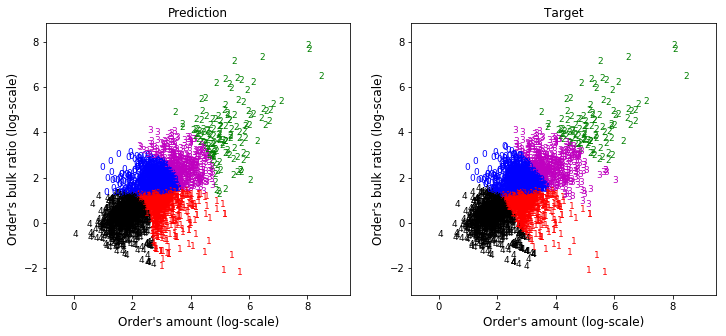

In [97]:
# Comparison subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
# Plot prediction
plot_labels(ax1, X_test_random_log.values, y_pred_svm)
ax1.set_title('Prediction')
# Plot target
plot_labels(ax2, X_test_random_log.values, y_test_random)
ax2.set_title('Target');

Except for a few values which seem to be mispredicted, nothing seems off about our prediction at first glance

THE DARKER THE MORE ACCURATE


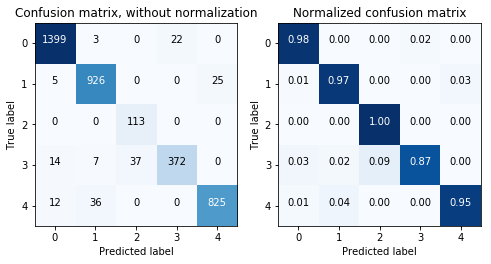

In [98]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_random, y_pred_svm)
np.set_printoptions(precision=2)
# Class names
class_names = list(set(y_test_random.tolist()))
# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
# Plot non-normalized confusion matrix
plot_confusion_matrix(ax1, cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(ax2, cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
print('\033[1m' + 'THE DARKER THE MORE ACCURATE' + '\033[0m')

The matrix talks for itself, the classifier is pretty accurate. A little less for 1 but there is few of them.

## 4.4) Conclusion on train/test split

While SVM presents better prediction results than logistic regression, temporal or random splitting does not make much difference on this dataset.

Our customers segment are in each case well representated and defined.

# 5) Conclusion and oppening

- We have successfully created **5 clusters of customers** with **different buying behaviours**.
- Our clustering is **based on customers _order's amount_ and _bulk tendency_**
    - One hidden hypothesis is that this bulk tendency and average amount is taken over a whole order, with several items in it. A customer buying only one item is likely to be a little less well predicted. But we are confident in our model as we consider average values.
- Other clustering based on the content of the customer first order has shown some qualities, but it did not make much sense in order to extract customers behaviours.
- A RFM (Recency-Frequency-MonetaryValue) based clustering showed promises as well but it could not comply with our constraint of categorising a customer based on its first order